# Čtení QR kódů řádkovou kamerou
Cvičení je zaměřené na práci s řádkovými kamerami, filtry a barevným osvětlením. Řádkové kamery jsou díky svým specifickým vlastnostem vynikající pro řadu úloh, typickým použitím je snímání nekonečného pásu ve výrobních linkách. Poněvadž nekonečné pásy nemáme v dostatečném počtu, budeme je simulovat pomocí povrchu otočného válce - plechovky. Na povrchu plechovky bude nalepen QR kód, který chceme přečíst.


## Potřebné knihovny
Je třeba mít nainstalovanou knihovnu [pyzbar](https://pypi.org/project/pyzbar/) - `pip install pyzbar`. Jedná se o pythoní wrapper okolo systémové knihovny zbar, takže tu je třeba mít také. Na windows je již nainstalována díky samotné instalaci pythonu, na linuxu a macu je potřeba ji doinstalovat zvlášť - `sudo apt-get install libzbar0
`, případně `brew install zbar`.

## Řádkové kamery
Řádková kamera neboli řádkový skener je speciální druh kamery, která snímá pouze 1 řádek. Díky tomu je schopna dosáhnout obrovských frekvencí snímání (až ticíce řádků za 1 sekundu). V labu máme kamery [Basler Racer](https://www.baslerweb.com/en/products/cameras/line-scan-cameras/racer/) o velikosti řádku 6k, 8k a 12k pixelů.

<img src="images/racer.png" width="25%">

Z podstaty skeneru však vyplývá, že se objekt pod kamerou musí pohybovat. V případě, že se objekt nebude pohybovat, vytvoří kamera obrázek, který bude mít všechny řádky totožné (pouze ten 1, který kamera snímá). 

Tím, že je kamera schopná dosahovat neskutečných frekvencí snímání dále umožňuje získávat obrazová data v neskutečně velkém rozlišení. Na druhou stranu nás tím nutí nastavovat nízkou dobu expozice a tedy je zapotřebí mnohem více světla.

Důležité pojmy související s řádkovými kamerami:
- **frame** - během komunikace s počítačem řádková kamera typicky neposílá každý řádek zvlášť, ale ukládá si je do lokálního bufferu a odesílá je pohromadě v jednom "frame" (rámci). Pylon Viewer pak řádky z jednoho frame zobrazuje v jednom obrázku, nad sebou. Počet řádků je možné v konfiguraci kamery nastavit parametrem *height*.
- **acquisition** - režim snímání kamery, typicky single shot/continuous. Single shot vyfotí pouze jeden frame, režim continuous rámce snímá nepřetržitě. V aplikacích jako jsou nekonečné pásy je možné použít buď single shot akvizici a mít zvláštní trigger pro každý objekt, nebo continuous akvizici a objekty rozlišovat v post-processingu.

---

### Import knihoven a konfigurace

In [1]:
! pip install pyzbar

In [2]:
from improutils import *
import pyzbar.pyzbar as pyzbar

### Úkol 1
Seznamte se s řádkovou kamerou a jejími parametry, jejichž nastavení je pro správné snímání kritické. Kamera se nejlépe zaostřuje na jakýkoliv černobílý či kontrastní barevný vzor. Ideálně jako čárový kód, ale jen s několika čárami. K tomuto účelu jsou pro vás vhodné obrázky vytištěny.

Sestavte snímací soustavu včetně osvětlení a zaostřete kameru. Vytvořte snímek zaostřeného vzorce svislých čar. Vložte obrázek sestavené snímací soustavy. <div style="color: blue; text-align: right">[ 1 bod ]</div>

In [ ]:
image = load_image('data/1_uloha.png') ###
plot_images(image)

---

### Úkol 2
Celou zaostřenou kameru pomocí kličky zdvihněte, aby byla kamera zaostřená na vršek plechovky (plechovka i s držákem je vysoká zhruba 6,4 cm). Nakonec získejte snímek QR kódu, který přečtěte a vizualizujte na původním snímku.

<div style="color: blue; text-align: right">[ 1 bod ]</div>

#### 1) Získejte snímek černobílého QR kódu
Za stálého otáčení plechovky zachyťte snímek černobílého QR kódu na jejím povrchu. Rychlost otáčení plechovky je třeba udržovat pokud možno konstantní, aby různé části snímku QR kódu nebyly různě protáhlé - knihovna, kterou používáme, by pak měla problém kód přečíst. Důležité také je, aby vyfocený QR kód byl co nejpodobnější obdélníku, tedy aby nebyl zkosený či jinak deformovaný.

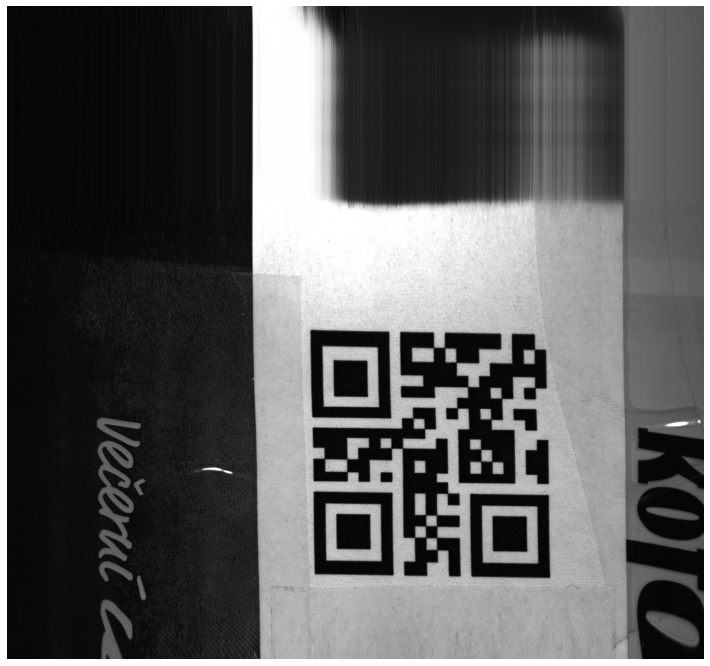

In [9]:
image = load_image('data/work.tiff') ###
plot_images(image)

In [11]:
image.shape

(4367, 4663, 3)

#### 2) Předzpracujte snímek QR kódu
V této sekci je nutné zejména přeškálovat obrázek tak, aby nebyl nevhodně protáhlý z důvodu nekorespondující snímkové frekvence vůči rychlosti otáčení plechovky. QR kód ve zpracovaném obrázku by měl být přibližně čtvercový (knihovna pyzbar, kterou použijeme ke čtení QR kódu, naštěstí poskytuje poměrně velkou toleranci). Obrázek můžete dále zpracovat dle libosti, například otočit nebo oříznout.

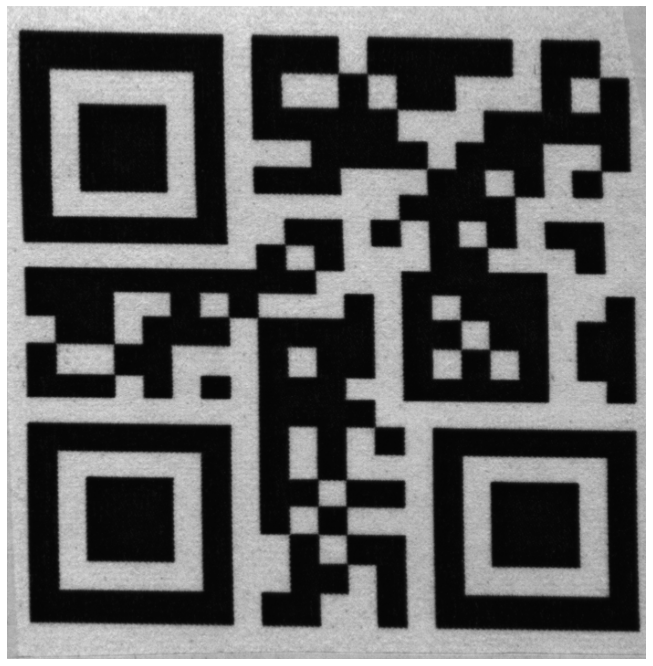

In [79]:
cropped_img = crop(image, 2000, 2100, 3650, 3900)

new_width, new_height = 700, 715 ###
resized_image = cv2.resize(cropped_img, (new_width, new_height)) ###
plot_images(resized_image)

In [84]:
show_images(resized_image)

x = 25, y = 676
x = 694, y = 687
x = 685, y = 35
x = 12, y = 26


In [86]:
src_pts = np.array([(25, 676), (694, 687), (685, 35), (12, 26)])
mul = 400
start = 20
dst_pts = np.array([(start, start + mul), (start + mul, start + mul), (start + mul, start), (start, start)])

H, mask = cv2.findHomography(src_pts, dst_pts) ###

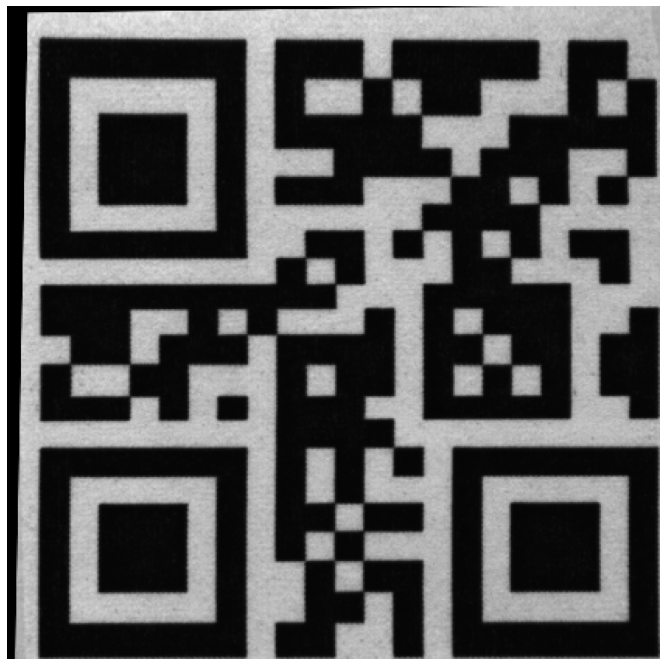

In [96]:
warped_img = cv2.warpPerspective(resized_image, H, (mul + start, mul + start)) ###
plot_images(warped_img)

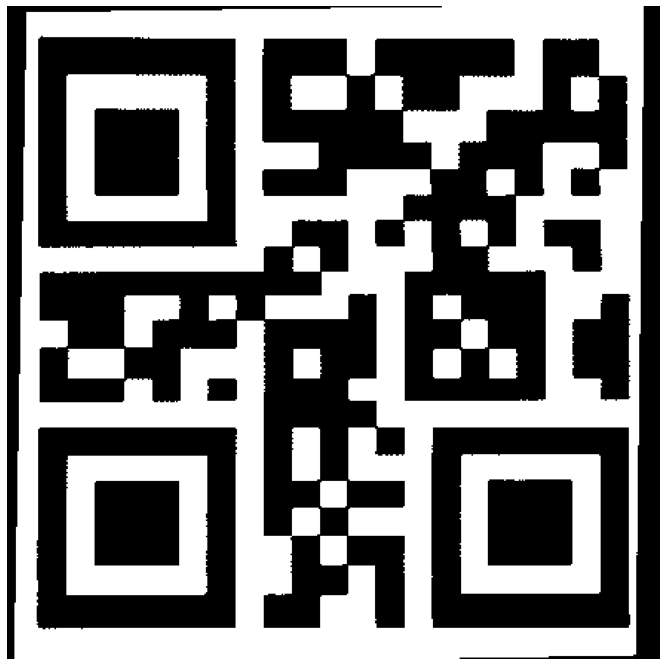

In [89]:
mask = segmentation_one_threshold(warped_img, 70)
plot_images(mask)

#### 3) Pomocí knihovy pyzbar přečtěte z QR kódu zakódovaný text a získejte souřadnice bounding boxu
Pro čtení QR kódu z obrázku používáme funkci `decode` knihovny pyzbar. Funkce vrací informace o všech detekovaných QR kódech - především jejich dekódovaná data a souřadnice v původním obrázku. Pokud funkce QR kód ve vašem obrázku nedetekuje, zkuste data nasnímat znovu a případně kontaktujte cvičící, kteří vám poradí, co by bylo vhodné ve snímku zlepšit.

In [94]:
def detect_qr_code(image):
    decoded_qr_codes = pyzbar.decode(image)
    print(decoded_qr_codes)
    qr_data = decoded_qr_codes[0].data
    qr_rect = decoded_qr_codes[0].rect
    
    return qr_data, qr_rect

In [95]:
qr_data, qr_rect = detect_qr_code(mask)
qr_data, qr_rect

[]


IndexError: list index out of range

Dekódovaná data vrací funkce ve formátu *bytes*, pro jejich převedení do řetězce je třeba provést další dekódování.

In [ ]:
qr_text = qr_data.decode('utf-8') # Převod do utf-8
print(qr_text)

#### 4) Do obrázku vykreslete ohraničující obdélník a vypište získaný text
Třešničkou na dortu je pro nás vizualizace QR kódu v obrázku - tj. zobrazení bounding boxu a vypsání dekódovaného textu vedle něj. K tomu je možné použít například funkce [cv2.rectangle()](https://docs.opencv.org/master/d6/d6e/group__imgproc__draw.html#ga07d2f74cadcf8e305e810ce8eed13bc9) a [cv2.putText()](https://docs.opencv.org/master/d6/d6e/group__imgproc__draw.html#ga5126f47f883d730f633d74f07456c576) knihovny opencv.

In [ ]:
annotated_image = resized_image.copy()
cv2.rectangle(annotated_image, (187, 60), (587, 433), (0, 255, 0), 3) ###
cv2.putText(annotated_image, qr_text, (220, 45), 0, 0.7, (0, 255, 0), 2) ###
plot_images(annotated_image)

---

### Bonus
Knihovna pyzbar nejlépe přečte QR kód tehdy, jestliže jsou čtverce v rozích kódu stejně velké. 
Nedodržením konstantní rychlosti otáčení plechovky mohou vzniknout deformace, které se nejvíce projeví například "protažením" pozicujících čtverců QR kódu. Bonusovým úkolem je detekce pozicujících čtverců a kontrola, zda jsou všechny stejné.

In [ ]:
### Vlastní postup

In [ ]:
def detect_qr_position_squares(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    bin_mask = segmentation_two_thresholds(gray_img, 0, 120)
    
    edges = cv2.Canny(bin_mask, 50, 150)
    _, num_contours, contours = find_contours(edges, 11000, 12500)
    
    print(num_contours)
    
    pos_squares = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        pos_squares.append((x, y, w, h))
    
    img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)
    contours_drawn = cv2.drawContours(img.copy(), contours, -1, color=(255, 0, 0), thickness=5)
    plot_images(contour_drawn)
    
    return pos_squares

In [ ]:
def check_position_squares_size(pos_squares):
    
    if len(pos_squares) != 3:
        